In [1]:
author="Jumabek Alikhanov"
date = 'Nov 17,2019'

This is Final Project material for the "Deep Learning" class I took  

## Download the dataset from https://www.unb.ca/cic/datasets/ids-2017.html
We only need CSV files that is preprocessed and labeled for ML 

In [2]:
#imports
import os
from os.path import join
import glob
import pandas as pd
import numpy as np
import time
%load_ext autoreload

In [3]:
# load data
dataroot = 'MachineLearningCVE/'

In [4]:
def read_data(dataroot,file_ending):
    if file_ending==None:
        print("please specify file ending pattern for glob")
        exit()
    print(join(dataroot,file_ending))
    filenames = [i for i in glob.glob(join(dataroot,file_ending))]
    combined_csv = pd.concat([pd.read_csv(f) for f in filenames],sort=False)
    return combined_csv

In [5]:
data = read_data(dataroot,'*.pcap_ISCX.csv')


MachineLearningCVE/*.pcap_ISCX.csv


/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/juma/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
num_records,num_features = data.shape
print("{} flow records read which has {} feature dimension".format(num_records,num_features))
# there is white spaces in columns names e.g. ' Destination Port'
# So strip the whitespace from  column names
data = data.rename(columns=lambda x: x.strip())

2830743 flow records read which has 79 feature dimension


In [7]:

df_label = data['Label']
# dropping bad columns, they coause issues due to large numbers
data = data.drop(columns=['Flow Packets/s','Flow Bytes/s','Label'])
#filling missing features
data.fillna(data.mean(), inplace=True)

In [8]:
#convert data to numeric
data = data.astype(float).apply(pd.to_numeric)

In [9]:
# lets count if there is NaN values in our dataframe( AKA missing features)
#we should see `0`
data.isnull().sum().sum()

0

In [10]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,22.0,1266342.0,41.0,44.0,2664.0,6954.0,456.0,0.0,64.975610,109.864573,...,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,22.0,1319353.0,41.0,44.0,2664.0,6954.0,456.0,0.0,64.975610,109.864573,...,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,22.0,160.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.0,1303488.0,41.0,42.0,2728.0,6634.0,456.0,0.0,66.536585,110.129945,...,24.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,35396.0,77.0,1.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# print label distribution
pd.DataFrame(df_label.value_counts()).to_csv(join(dataroot,'class_distribution.csv'))
df_label.value_counts()

BENIGN                        2273097
DoS Hulk                       231073
PortScan                       158930
DDoS                           128027
DoS GoldenEye                   10293
FTP-Patator                      7938
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1966
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

## Data Imbalance
1. It is curucial to adress this issue in order to get decent performance
2. It also affects evaluation, we should calculate accuracy for balanced data

In [12]:
#Since the above data is imbalanced we do oversampling to balance data
def balance_data(X,y):
    unique,counts = np.unique(y,return_counts=True)
    mean_samples_per_class = int(round(np.mean(counts)))
    new_X = np.empty((0,X.shape[1]))
    new_y = np.empty((0),dtype=int)
    for i,c in enumerate(unique):
        temp_x = X[y==c]
        indices = np.random.choice(temp_x.shape[0],mean_samples_per_class)
        new_X = np.concatenate((new_X,temp_x[indices]),axis=0)
        temp_y = np.ones(mean_samples_per_class,dtype=int)*c
        new_y = np.concatenate((new_y,temp_y),axis=0)

    # in order to break class order in data we need shuffling
    indices = np.arange(new_y.shape[0])
    np.random.shuffle(indices)
    new_X =  new_X[indices,:]
    new_y = new_y[indices]
    return (new_X,new_y)


In [13]:
# chganges label from string to integer/index
def encode_label(Y_str):
    labels_d = make_value2index(np.unique(Y_str))
    Y = [labels_d[y_str] for y_str  in Y_str]
    Y = np.array(Y)
    return np.array(Y)

def make_value2index(attacks):
    #make dictionary
    attacks = sorted(attacks)
    d = {}
    counter=0
    for attack in attacks:
        d[attack] = counter
        counter+=1
    return d


In [14]:
# normalization
def normilize(data):
        data = data.astype(np.float32)
       
        eps = 1e-15
        if len(data[data>=0])<=0: # make sure we actually have at least one none -1 feature
            return

        mask = data==-1
        data[mask]=0
        mean_i = np.mean(data,axis=0)
        min_i = np.min(data,axis=0) #  to leave -1 features as is and exclude in normilizing
        max_i = np.max(data,axis=0)

        r = max_i-min_i+eps
        data = (data-mean_i)/r  # zero centered norm [-0.5,0.5]
        #deal with edge case -1
        data[mask] = 0
        
        nan_index = np.isnan(data)
        nan_data = data[nan_index]
        
        return data

In [15]:
from sklearn import preprocessing
data_np = data.values # convert to numpy array
X = data_np
X = normilize(X)
#X = preprocessing.scale(X)
y = df_label.values
y = encode_label(y)
N = X.shape[0]
print(X.shape,y.shape)

(2830743, 76) (2830743,)


In [16]:

%autoreload 2
from shallows import LinearClassifier
from neural_network import NetClassifier

def ensure_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

def getClassifier(args=None,runs_dir=None):
    if args is not None:
        (_,optim,lr,reg,batch_size,input_dim,num_class) = args
    if runs_dir is not None:
        ensure_dir(runs_dir)
    
    num_epochs = 60
    
    clf = NetClassifier(input_dim,num_class,lr=lr,reg=reg,num_epochs=num_epochs,
                        batch_size=batch_size,runs_dir=runs_dir,use_batchnorm=True)
    return clf


In [17]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=2)


In [18]:

#hyper-params
batch_size = 5*1024 # increasing batch size with more gpu added
optim = 'Adam'

input_dim = X_train.shape[1]
num_class = len(np.unique(y_train))

accuracies = {}
learning_rates = [1e-5,1e-4,3e-4]
regularizations = [1e-6,1e-5,1e-4,1e-3]
best_model = None
best_acc = -1
num_layers = 5
run=5
e_time = len(learning_rates)*len(regularizations)*800/60
print("estimated time is {} minutes".format(e_time))
for lr in learning_rates:
    for reg in regularizations:

        classifier_args = ('softmax',optim,lr,reg,batch_size,input_dim,num_class)
        config =  '{}_layer_relu_nn/{}th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(num_layers,run,optim,lr,reg,batch_size)
        runs_dir = join(dataroot,'runs',config)
        
        X_train = X_train.astype(float)
        y_train = y_train.astype(int)
        p = np.random.permutation(len(y_train))
        X_train = X_train[p]
        y_train = y_train[p]
        X_train,y_train = balance_data(X_train,y_train)

        tick = time.time()
        clf = getClassifier(classifier_args,runs_dir)
        
        #clf.fit(X_train,y_train,X_val,y_val,verbose=False)
        raw_pred,pred = clf.predict(X_val,eval_mode=True)
        
        acc = metrics.balanced_accuracy_score(y_val,pred)
        if acc >best_acc:
            best_model = clf
            best_acc = acc
        accuracies[(lr,reg)]=acc
        tock = time.time()
        print("Model is trained in {} sec".format(tock-tick))

estimated time is 160.0 minutes
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_1e-06_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 300 mini batches
Model is trained in 4.783338308334351 sec
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_1e-05_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 150 mini batches
Model is trained in 1.1973540782928467 sec
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_0.0001_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 100 mini batches
Model is trained in 1.1812899112701416 sec
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_0.001_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 350 mini batches
Model is trained in 1.2415952682495117 sec
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_0.0001_reg_1e-06_bs_5120 model trained with batch_size = 51

In [19]:
#ensamble
def get_ensamble_accuracy(X,y):
    raw_pred_sum = np.zeros((y.shape[0],num_class))
    num_models = 1#len(learning_rates)*len(regularizations)
    for lr in learning_rates:
        for reg in regularizations:
            classifier_args = ('softmax',optim,lr,reg,batch_size,input_dim,num_class)
            config =  '{}_layer_relu_nn/{}th_run/optim_{}_lr_{}_reg_{}_bs_{}'.format(num_layers,run,optim,lr,reg,batch_size)
            runs_dir = join(dataroot,'runs',config)
            clf = getClassifier(classifier_args,runs_dir)        
            raw_pred,pred= clf.predict(X,eval_mode=True)
            print(raw_pred.shape,pred.shape)
            raw_pred_sum += raw_pred
                        
    raw_pred =raw_pred_sum/num_models
    pred = np.argmax(raw_pred,axis=1)
    acc = metrics.balanced_accuracy_score(y,pred)*100
    print('{0} model ensamble acc is {1:.2f} '.format(num_models,acc))
    return acc

In [20]:

val_acc = get_ensamble_accuracy(X_val,y_val)
test_acc = get_ensamble_accuracy(X_test,y_test)
print("Accuracies for val/test sets {0:.2f}/{1:.2f}".format(val_acc,test_acc))

Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_1e-06_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 300 mini batches
(226460, 15) (226460,)
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_1e-05_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 150 mini batches
(226460, 15) (226460,)
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_0.0001_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 100 mini batches
(226460, 15) (226460,)
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_1e-05_reg_0.001_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 350 mini batches
(226460, 15) (226460,)
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_0.0001_reg_1e-06_bs_5120 model trained with batch_size = 5120, seen 59 epochs and 200 mini batches
(226460, 15) (226460,)
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5

In [21]:
raw_pred,pred = best_model.predict(X_test,eval_mode=True)        
test_acc = metrics.balanced_accuracy_score(y_test,pred)*100

raw_pred,pred = best_model.predict(X_val,eval_mode=True)        
val_acc = metrics.balanced_accuracy_score(y_val,pred)*100

print("val acc of best model ",val_acc)
print("test acc of best model ",test_acc)

Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_0.0001_reg_1e-05_bs_5120 model trained with batch_size = 5120, seen 57 epochs and 0 mini batches
Loaded MachineLearningCVE/runs/5_layer_relu_nn/5th_run/optim_Adam_lr_0.0001_reg_1e-05_bs_5120 model trained with batch_size = 5120, seen 57 epochs and 0 mini batches
val acc of best model  91.1445743762908
test acc of best model  89.12953471998712


In [22]:
# accuracies for CV
for x in accuracies:
    print(x)
    print(accuracies[x])
results = accuracies  

(1e-05, 1e-06)
0.8614306319439068
(1e-05, 1e-05)
0.855652895878211
(1e-05, 0.0001)
0.8548059574246667
(1e-05, 0.001)
0.8456788271687843
(0.0001, 1e-06)
0.8898703687047413
(0.0001, 1e-05)
0.911445743762908
(0.0001, 0.0001)
0.8905671243798501
(0.0001, 0.001)
0.8752224428388402
(0.0003, 1e-06)
0.8914955805079766
(0.0003, 1e-05)
0.8811165585108397
(0.0003, 0.0001)
0.9073367832993176
(0.0003, 0.001)
0.8921749380061679


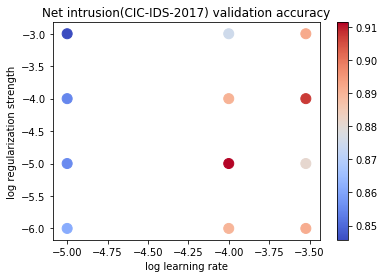

In [24]:
# Visualize the cross-validation results
import math
import matplotlib.pyplot as plt
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]


# plot validation accuracy
marker_size=100
colors = [results[x] for x in results] # default size of markers is 20

plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('Net intrusion(CIC-IDS-2017) validation accuracy')
plt.savefig('MachineLearningCVE/5_layers_relu_{}th_run.png'.format(run))
plt.show()